In [1]:
from typing import Tuple
import pickle
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from experiments.util import load_data

from sklearn.model_selection import train_test_split

In [2]:
X_data, y_data = load_data()

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

#### CNN

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, activations, Sequential, losses

def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def baseline_model():
    model = Sequential([
        layers.InputLayer(input_shape=(32, 32, 3), name='input_layer'),
        layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_1'),
        layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_2'),
        layers.Flatten(),
        layers.Dense(10, activation=activations.softmax, name='output_layer'),
        layers.Softmax()
    ])
    model.compile(
        optimizer='adam',
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

##### Preprocessing

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

###### Simple 0-1 scaling

Epoch 1/40
293/293 [==============================] - 11s 36ms/step - loss: 2.2797 - accuracy: 0.2706 - val_loss: 2.2731 - val_accuracy: 0.3146

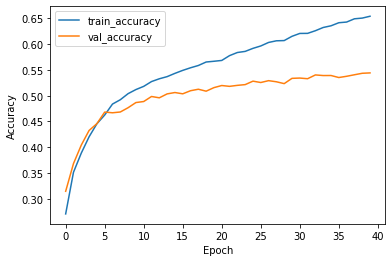

In [13]:
X_train_scaled = X_train / 255
X_val_scaled = X_val / 255

model = baseline_model()
history = model.fit(X_train_scaled, y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_scaled, y_val_enc))
plot_history(history)

###### tf.image.per_image_standardization

Epoch 1/40
293/293 [==============================] - 14s 43ms/step - loss: 2.2686 - accuracy: 0.3495 - val_loss: 2.2602 - val_accuracy: 0.4037

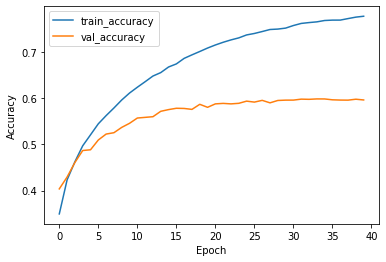

In [14]:
X_train_std = tf.image.per_image_standardization(X_train)
X_val_std = tf.image.per_image_standardization(X_val)

model = baseline_model()
history = model.fit(X_train_std, y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std, y_val_enc))
plot_history(history)

In [ ]:
%%time

# Neural Network mit zwei Hidden Convolution Layers
model = Sequential([
    layers.InputLayer(input_shape=(32, 32, 3), name='input_layer'),
    layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_1'),
    layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_2'),
    layers.Conv2D(196, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_3'),
    layers.Flatten(),
    layers.Dense(10, activation=activations.softmax, name='output_layer'),
    layers.Softmax()
])

print(model.summary())

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

history = model.fit(X_train_std, y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std, y_val_enc))
plot_history(history)

y_val_hat_prob = model.predict(X_val_std)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Conv2D)      (None, 15, 15, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 64)        256       
_________________________________________________________________
hidden_layer_2 (Conv2D)      (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
hidden_layer_3 (Conv2D)      (None, 3, 3, 196)         225988    
_________________________________________________________________
flatten_8 (Flatten)          (None, 1764)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1764)             

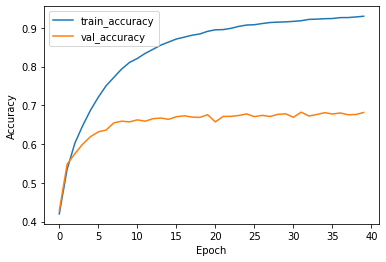

0.6816
CPU times: user 1h 37min 55s, sys: 48min 18s, total: 2h 26min 14s
Wall time: 24min 43s


In [18]:
%%time

# Neural Network mit zwei Hidden Convolution Layers
model = Sequential([
    layers.InputLayer(input_shape=(32, 32, 3), name='input_layer'),
    layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_1'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_2'),
    layers.BatchNormalization(),
    layers.Conv2D(196, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_3'),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation=activations.gelu, name='hidden_layer_4'),
    layers.BatchNormalization(),
    layers.Dense(10, activation=activations.softmax, name='output_layer'),
    layers.Softmax()
])

print(model.summary())

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

history = model.fit(X_train_std, y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std, y_val_enc))
plot_history(history)

y_val_hat_prob = model.predict(X_val_std)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### Data Augmentation

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 32, 32, 3)         0         
_________________________________________________________________
hidden_layer_1 (Conv2D)      (None, 15, 15, 64)        1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 15, 64)        256       
_________________________________________________________________
hidden_layer_2 (Conv2D)      (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
hidden_layer_3 (Conv2D)      (None, 3, 3, 196)       

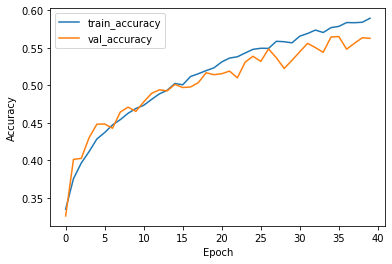

0.56256


In [21]:
# Check out: `layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom`, and others.
model_da = Sequential([
    layers.InputLayer(input_shape=(32, 32, 3), name='input_layer'),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_1'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_2'),
    layers.BatchNormalization(),
    layers.Conv2D(196, kernel_size=(3, 3), strides=(2, 2), activation=activations.gelu, name='hidden_layer_3'),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation=activations.gelu, name='hidden_layer_4'),
    layers.BatchNormalization(),
    layers.Dense(10, activation=activations.softmax, name='output_layer'),
    layers.Softmax()
])

print(model_da.summary())

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

model_da.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

history = model_da.fit(X_train_std, y_train_enc, batch_size=128, epochs=100, validation_data=(X_val_std, y_val_enc))
plot_history(history)

y_val_hat_prob = model_da.predict(X_val_std)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

In [29]:
# Taken from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
model = Sequential([
    layers.Conv2D(32, (3, 3), activation=activations.gelu, padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation=activations.gelu, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation=activations.gelu, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation=activations.gelu, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation=activations.gelu, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation=activations.gelu, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Softmax()
])
print(model.summary())

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

history = model.fit(X_train_std, y_train_enc, batch_size=128, epochs=100, validation_data=(X_val_std, y_val_enc))
plot_history(history)

y_val_hat_prob = model.predict(X_val_std)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 16, 64)      

KeyboardInterrupt: 